In [1]:
import pandas as pd
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
import plotly
import plotly.express as px
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# загрузим данные
df = pd.read_csv("./data/segmented_customers.csv")
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:



In [3]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [4]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [5]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [6]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df.head()


,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,4.0
1,2,1,21.0,15.0,81.0,3.0
2,3,0,20.0,16.0,6.0,4.0
3,4,0,23.0,16.0,77.0,3.0
4,5,0,31.0,17.0,40.0,4.0


3
Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст. Визуализируем распределение данных:

In [7]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
  data_frame=df,
  x='age',
  y= 'annual_income',
  z = 'spending_score',
  width=1000,
  height=700
)
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [8]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [9]:
# Сохраним признаки, по которым будем проводить моделирование, в переменную X:
X = df[['age', 'annual_income', 'spending_score']]





![Скриншот](./img//Screenshot_42.png)


<Axes: xlabel='annual_income', ylabel='spending_score'>

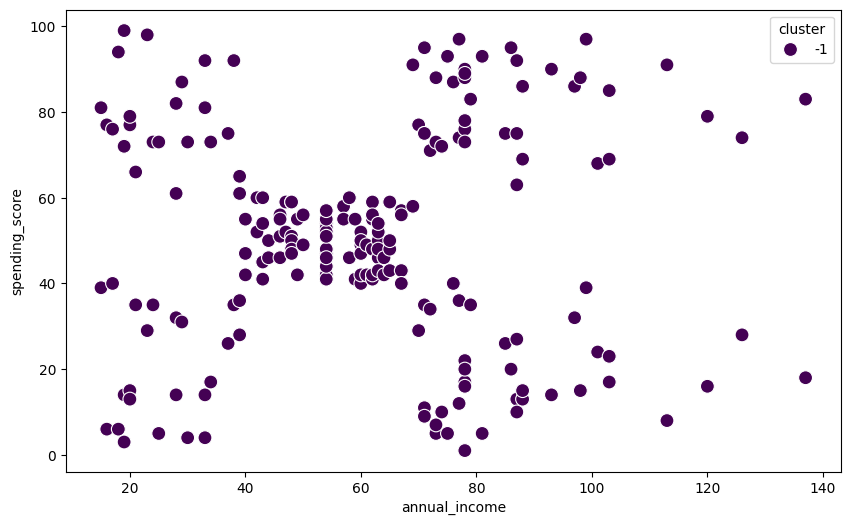

In [13]:
dbscan = DBSCAN()
df['cluster'] = dbscan.fit_predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='annual_income', 
    y='spending_score', 
    hue='cluster', 
    data=df, 
    palette='viridis', 
    style='cluster',
    s=100
)


In [18]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=12)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [19]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

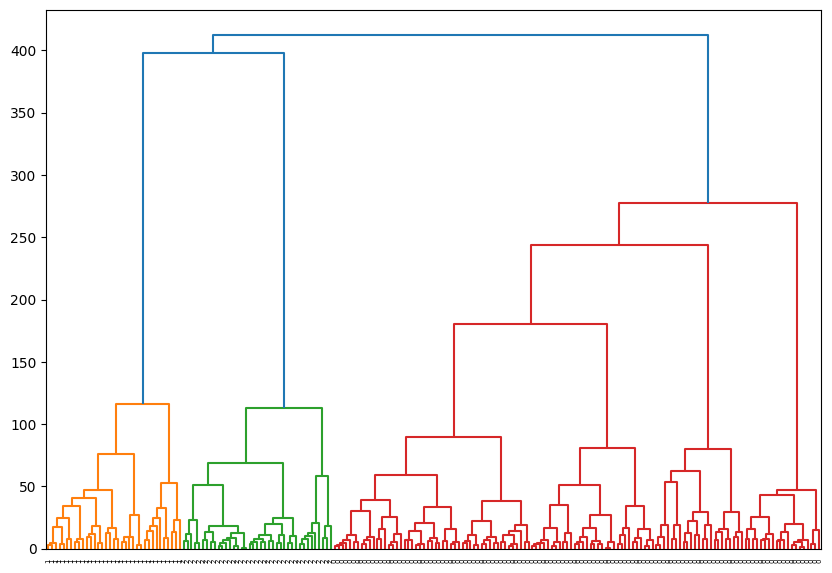

In [23]:
pred = get_aggl_clustering(X,3)
df['aglo_labels'] = pred
# импортируем библиотеку scipy, чтобы визуализировать дендрограмму
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# запускаем агломеративную кластеризацию и сохраним результаты в df
df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

Давайте визуально оценим, что из этого получилось. Для этого обучим модель агломеративной кластеризации с количеством кластеров, равным 6:

In [24]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. Сколько кластеров у вас получилось?

<Axes: xlabel='cluster', ylabel='silhouette'>

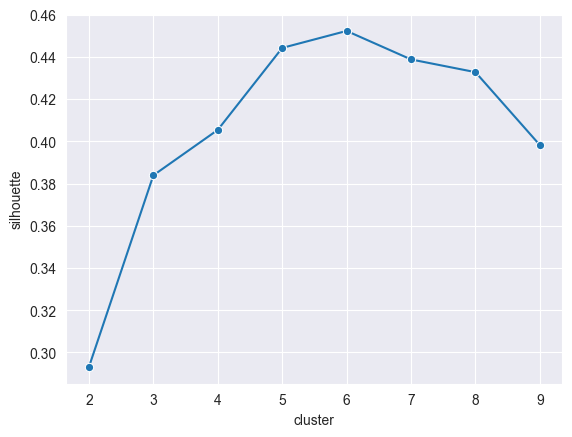

In [26]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def get_silhouette(cluster_num, X):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette
# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}



for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

Как видим, пик коэффициента силуэта находится на значении 6. Таким образом, оптимальное количество кластеров — 6.

9
Теперь рассмотрим столбец cluster: в нём есть информация о том, к какому кластеру должен принадлежать каждый объект из датасета. Значит, мы можем проверить качество кластеризации, посчитав различные метрики.



Метрику полноты можно вызвать из модуля cluster библиотеки sklearn. Метрика рассчитывается следующим образом: